# Training

In [65]:
'''
@Jaejun Lee copyright
Incosistency and differentiable cycle gan fro grain boundary detetction.
'''
#Other common modules
%cd /content/drive/MyDrive/acta
import os
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import albumentations
import cv2
import json
import time
from matplotlib import gridspec
from glob import glob
from PIL import Image
from pathlib import Path

#Pytorch
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

#import my own modules
from datadiversity import *
from DiffAugment_pytorch import *
from consistencyimage import *
from cyclegan import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

with open("./path.json","r") as file:
    domain = json.load(file)

class ImageDataset(Dataset):

    # input: image files
    # output: dataset class of transformed images

    def __init__(self,Name,domain_A_file,domain_B_folder, transforms_ = None):
        self.transform = transforms_
        self.Name = Name
        self.domain_A_file = domain_A_file
        self.domain_B_file = glob(domain_B_folder + '/' + "*.*")

    def __getitem__(self, index):
        domain_A = Image.open(self.domain_A_file)
        domain_B = Image.open(self.domain_B_file[random.randint(0, len(self.domain_B_file) - 1)])

        if domain_A.mode == "RGB":
            domain_A = to_gray(domain_A)
        if domain_B.mode == "RGB":
            domain_B = to_gray(domain_B)

        domain_A = self.transform(domain_A)
        domain_B = self.transform(domain_B)

        return {"A": domain_A, "B": domain_B}

    def __len__(self):
        return max(len(self.domain_A_file), len(self.domain_B_file))

transforms_ = transforms.Compose([
    transforms.RandomCrop((256, 256)),
    transforms.RandomResizedCrop(size = 256, scale = (0.75, 1.), ratio = (0.75, 1.33)),
    transforms.ToTensor()
])

# build dataset class
train_dataset = ImageDataset(Name = "magnesium_169.jpg",domain_A_file = domain["domain_A_file"],domain_B_folder = domain["domain_B_folder"], transforms_ = transforms_)
val_dataset = ImageDataset(Name = "magnesium_169.jpg",domain_A_file =  domain["domain_A_file"],domain_B_folder = domain["domain_B_folder"],transforms_ = transforms_)


# build dataloader class
train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle = True, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = True, num_workers = 0)

for batch in val_dataloader:
    real_A_ = batch["A"].cuda()
    real_B_ = batch["B"].cuda()
    real_A = make_grid(real_A_, normalize=False).cpu()
    real_B = make_grid(real_B_, normalize=False).cpu()
    img_grid = torch.cat((real_A,real_B),2)
    img_grid = img_grid.cpu()
    break
missing_B = random_rand_cutout(real_B_,min=8,max=32)

def total_white_show(real_A,real_B):


    #zoom out
    large = transforms_zoom_out(real_B_[0])
    large_B_grid = make_grid(large,normalize=False).cpu()

    #missing
    missing = transforms_missing_boundary(real_B_[0])
    missing_B_grid = make_grid(missing,normalize = False).cpu()

    #zoom in
    small = transforms_zoom_in(real_B_[0])
    small_B_grid = make_grid(small,normalize=False).cpu()


    # zoom in missing boundary

    small = transforms_missing_boundary(small)
    small_B_missing_grid = make_grid(small,normalize=False).cpu()

    plt.figure(figsize=(30,30))
    img_total = torch.cat((real_A,real_B,missing_B_grid,large_B_grid,small_B_grid,small_B_missing_grid),2).permute(1,2,0)
    img_total = img_total.cpu()
    plt.axis("off")
    plt.imshow(img_total)
    plt.show()

def valid_show_random_cropout(real_A,real_B):

    #translation
    translation = DiffAugment(real_B_,"translation")
    translation_grid = make_grid(translation, normalize=False).cpu()
    pil_image = tensor_to_pil(translation[0])


    #missing boundary
    missing_B = random_rand_cutout(real_B_,min=8,max=32)
    missing_B_grid = make_grid(missing_B, normalize = False).cpu()
    torch_image = random_rand_cutout(real_B_,min=8,max=32)
    pil_image = tensor_to_pil(torch_image[0])

    #zoom out
    large = transforms_zoom_out(real_B_[0])
    large_B_grid = make_grid(large,normalize=False).cpu()
    pil_image = tensor_to_pil(large[0])


    #zoom out for missing boundary image
    large = torch.unsqueeze(large,0)
    large = random_rand_cutout(large,min=32,max=40)
    large_B_missing_grid = make_grid(large,normalize=False).cpu()
    pil_image = tensor_to_pil(large[0])


    #zoom in
    small = transforms_zoom_in(real_B_[0])
    small_B_grid = make_grid(small,normalize=False).cpu()
    pil_image = tensor_to_pil(small[0])


    # zoom in missing boundary
    small = torch.unsqueeze(small,0)
    small = random_rand_cutout(small,min=8,max=32)
    small_B_missing_grid = make_grid(small,normalize=False).cpu()
    pil_image = tensor_to_pil(small[0])


    plt.figure(figsize=(30,30))
    img_total = torch.cat((real_A,real_B,translation_grid,missing_B_grid,large_B_grid,large_B_missing_grid,small_B_grid,small_B_missing_grid),2).permute(1,2,0)
    img_total = img_total.cpu()
    plt.axis("off")
    plt.imshow(img_total)
    plt.show()

def valid_show_line_cutout(real_A,real_B):

    #translation
    translation = DiffAugment(real_B_,"translation")
    translation_grid = make_grid(translation, normalize=False).cpu()
    pil_image = tensor_to_pil(translation[0])


    #missing boundary
    missing_B = line_cutout(real_B_)
    missing_B_grid = make_grid(missing_B, normalize = False).cpu()
    # torch_image = line(real_B_,min=8,max=32)
    # pil_image = tensor_to_pil(torch_image[0])

    #zoom out
    large = transforms_zoom_out(real_B_[0])
    large_B_grid = make_grid(large,normalize=False).cpu()
    pil_image = tensor_to_pil(large[0])


    #zoom out for missing boundary image
    large = torch.unsqueeze(large,0)
    large = line_cutout(large)
    large_B_missing_grid = make_grid(large,normalize=False).cpu()
    pil_image = tensor_to_pil(large[0])


    #zoom in
    small = transforms_zoom_in(real_B_[0])
    small_B_grid = make_grid(small,normalize=False).cpu()
    pil_image = tensor_to_pil(small[0])


    # zoom in missing boundary
    small = torch.unsqueeze(small,0)
    small = line_cutout(small)
    small_B_missing_grid = make_grid(small,normalize=False).cpu()
    pil_image = tensor_to_pil(small[0])


    plt.figure(figsize=(30,30))
    img_total = torch.cat((real_A,real_B,translation_grid,missing_B_grid,large_B_grid,large_B_missing_grid,small_B_grid,small_B_missing_grid),2).permute(1,2,0)
    img_total = img_total.cpu()
    plt.axis("off")
    plt.imshow(img_total)
    plt.show()

def valid_show_random_line_cutout(real_A,real_B):

    #translation
    translation = DiffAugment(real_B_,"translation")
    translation_grid = make_grid(translation, normalize=False).cpu()
    pil_image = tensor_to_pil(translation[0])


    #missing boundary
    missing_B = line_le_cutout(real_B_)
    missing_B_grid = make_grid(missing_B, normalize = False).cpu()
    # torch_image = line(real_B_,min=8,max=32)
    # pil_image = tensor_to_pil(torch_image[0])

    #zoom out
    large = transforms_zoom_out(real_B_[0])
    large_B_grid = make_grid(large,normalize=False).cpu()
    pil_image = tensor_to_pil(large[0])


    #zoom out for missing boundary image
    large = torch.unsqueeze(large,0)
    large = line_le_cutout(large)
    large_B_missing_grid = make_grid(large,normalize=False).cpu()
    pil_image = tensor_to_pil(large[0])


    #zoom in
    small = transforms_zoom_in(real_B_[0])
    small_B_grid = make_grid(small,normalize=False).cpu()
    pil_image = tensor_to_pil(small[0])


    # zoom in missing boundary
    small = torch.unsqueeze(small,0)
    small = line_le_cutout(small)
    small_B_missing_grid = make_grid(small,normalize=False).cpu()
    pil_image = tensor_to_pil(small[0])


    plt.figure(figsize=(30,30))
    img_total = torch.cat((real_A,real_B,translation_grid,missing_B_grid,large_B_grid,large_B_missing_grid,small_B_grid,small_B_missing_grid),2).permute(1,2,0)
    img_total = img_total.cpu()
    plt.axis("off")
    plt.imshow(img_total)
    plt.show()

def black_total_show(real_A,real_B):
    random_seed = 14
    np.random.seed(random_seed)
    # torch.manual_seed(random_seed)
    valid_show_random_cropout(real_A,real_B)
    valid_show_line_cutout(real_A,real_B)
    valid_show_random_line_cutout(real_A,real_B)


#Defube basis model

G_AB = GeneratorResNet(input_shape = (1, 256, 256), num_residual_blocks = 9)
G_BA = GeneratorResNet(input_shape = (1, 256, 256), num_residual_blocks = 9)
D_A = Discriminator(input_shape = (1, 256, 256))
D_B = Discriminator(input_shape = (1, 256, 256))


G_AB.cuda()
G_BA.cuda()
D_A.cuda()
D_B.cuda()

# weight initialization
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)


# define loss function
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()
criterion_cr = torch.nn.MSELoss()

criterion_GAN.cuda()
criterion_cycle.cuda()
criterion_identity.cuda()
criterion_cr.cuda()

n_epoch = int(50)
decay_epoch = int(600)
lr = 0.0002


# define optimizer
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr = lr, betas = (0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr = lr, betas = (0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr = lr, betas = (0.5, 0.999))


# learning rate scheduler
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda = LambdaLR(n_epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda = LambdaLR(n_epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda = LambdaLR(n_epoch, decay_epoch).step)

# White
def white_normal(Name,file_path,folder_path):

    n_prt = 50
    n_epoch = 1200

    # loss function weight

    lambda_cycle = 10
    lambda_identity = 5

    # buffer
    fake_A_buffer = ReplayBuffer()
    fake_B_buffer = ReplayBuffer()

    semi_name = "normal"
    name = Name

    folder = Path(folder_path + "/" + semi_name + "/" + name,exist_okay=True)
    Path(folder).mkdir(parents=True,exist_ok = True)

    result_folder = Path(folder_path + "/" + semi_name + "/" + name + "/" + "result",exist_okay = True)
    Path(result_folder).mkdir(parents=True,exist_ok = True)
    result_folder = folder_path + "/" + semi_name + "/" + name + "/" + "result"

    ckpt_folder = Path(folder_path + "/" + semi_name + "/" + name + "/" + "ckpt_files", exist_okay = True)
    Path(ckpt_folder).mkdir(parents = True, exist_ok = True)
    ckpt_folder = folder_path + "/" + semi_name + "/" + name + "/" + "ckpt_files"

    training_folder = Path(folder_path + "/" + semi_name + "/" + name + "/" + "training_files", exist_okay = True)
    Path(training_folder).mkdir(parents = True, exist_ok = True)
    training_folder = folder_path + "/" + semi_name + "/" + name + "/" + "training_files"

    test_image = np.array(to_gray(Image.open(file_path)))


    start_time = time.time()

    n_epoch = 1200

    for epoch in range(1, n_epoch):

        for i, batch in enumerate(train_dataloader):

            # load batch images
            real_A = batch['A'].cuda() # domain_A_real
            real_B = batch['B'].cuda() # domain_B_real

            # make label for discriminators
            real = torch.cuda.FloatTensor(real_A.shape[0], 1, 16, 16).fill_(1.0) # real_label
            fake = torch.cuda.FloatTensor(real_A.shape[0], 1, 16, 16).fill_(0.0) # fake_label

            '''
            ----------------------------------------------------------------------------------------------------------
            generator training
            ----------------------------------------------------------------------------------------------------------
            '''

            # mode
            G_AB.train()
            G_BA.train()

            # zero gradient
            optimizer_G.zero_grad()

            loss_identity_A = criterion_identity(G_BA(real_A), real_A) # identity_loss_A
            loss_identity_B = criterion_identity(G_AB(real_B), real_B) # identity_loss_B
            loss_identity = (loss_identity_A + loss_identity_B) / 2 #identity_loss

            fake_B = G_AB(real_A)
            fake_A = G_BA(real_B)

            # Create missing_boundary image
            # missing_real_B = torch.unsqueeze(transforms_missing_boundary(real_B.cpu()[0]), 0).cuda()
            # missing_fake_B = torch.unsqueeze(transforms_missing_boundary(fake_B.cpu()[0]),0).cuda()

            # adversarial_loss

            loss_GAN_AB = criterion_GAN(D_B(fake_B), real) # adversarial_loss_AB
            loss_GAN_BA = criterion_GAN(D_A(fake_A), real) # adversarial_loss_BA

            loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2

            recover_A = G_BA(fake_B)
            recover_B = G_AB(fake_A)
            loss_cycle_A = criterion_cycle(recover_A, real_A) # consistency_loss_A
            loss_cycle_B = criterion_cycle(recover_B, real_B) # consistency_loss_B
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2 # consistency_loss

            loss_G = loss_GAN + lambda_cycle * loss_cycle + lambda_identity * loss_identity # G_loss

            # update gradient
            loss_G.backward()
            optimizer_G.step()

            '''
            ----------------------------------------------------------------------------------------------------------
            discriminator A training
            ----------------------------------------------------------------------------------------------------------
            '''

            # zero gradient
            optimizer_D_A.zero_grad()

            # loss
            loss_real = criterion_GAN(D_A(real_A), real)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)

            #Create missing boundary image for fake_A_
            loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)

            #Create zoom out and zoom in image for real_A
            zoom_out_real_A = torch.unsqueeze(transforms_zoom_out(real_A.cpu()[0]),0).cuda()
            zoom_in_real_A = torch.unsqueeze(transforms_zoom_in(real_A.cpu()[0]),0).cuda()

            #Create zoom out and zoom in image for fkae_A
            zoom_out_fake_A = torch.unsqueeze(transforms_zoom_out(fake_A_.detach().cpu()[0]),0).cuda()
            zoom_in_fake_A = torch.unsqueeze(transforms_zoom_in(fake_A_.detach().cpu()[0]),0).cuda()

            #loss consistency_regularization
            loss_cr = (criterion_cr(D_A(real_A), D_A(torch.unsqueeze(transforms_zoom_out(real_A.cpu()[0]), 0).cuda())) + \
                   criterion_cr(D_A(real_A), D_A(torch.unsqueeze(transforms_zoom_in(real_A.cpu()[0]), 0).cuda()))) / 2


            #loss for discriminator
            loss_D_A = (loss_real + loss_fake) / 2 + loss_cr

            # update gradient
            loss_D_A.backward()
            optimizer_D_A.step()

            '''
            ----------------------------------------------------------------------------------------------------------
            discriminator B training (inconsistency loss)
            ----------------------------------------------------------------------------------------------------------
            '''
            # zero gradient
            optimizer_D_B.zero_grad()

            # loss
            loss_real = criterion_GAN(D_B(real_B), real)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)

            # loss consistency_regularization
            loss_cr = (criterion_cr(D_B(real_B), D_B(torch.unsqueeze(transforms_zoom_out(real_B.cpu()[0]), 0).cuda())) + \
                       criterion_cr(D_B(real_B), D_B(torch.unsqueeze(transforms_zoom_in(real_B.cpu()[0]), 0).cuda()))) / 2


            loss_icr = criterion_cr(1-D_B(real_B),D_B(torch.unsqueeze(transforms_missing_boundary(real_B.cpu()[0]),0).cuda()))

            loss_D_B = (loss_real + loss_fake) / 2 + loss_cr + loss_icr

            # update gradient
            loss_D_B.backward()
            optimizer_D_B.step()

            ''' print '''
            loss_D = (loss_D_A + loss_D_B) / 2
            done = (epoch - 1) * len(train_dataloader) + i

        print(f"[Epoch {epoch} / {n_epoch}] [D loss: {loss_D.item():.6f}] [G identity loss: {loss_identity.item():.6f}, G adv loss: {loss_GAN.item():.6f}, G cycle loss: {loss_cycle.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

        ppoch = f"/{epoch}.png"

        if epoch % 2 == 0:
            fake_B_ = G_AB(real_A_)
            fake_A_ = G_BA(real_B_)
            fake_A_missing = G_BA(missing_B)

            real_A = make_grid(real_A_, nrow = 5, normalize = False)
            real_B = make_grid(real_B_, nrow = 5, normalize = False)
            fake_A = make_grid(fake_A_, nrow = 5, normalize = False)
            fake_B = make_grid(fake_B_, nrow = 5, normalize = False)
            fake_missing = make_grid(fake_A_missing,nrow = 5, normalize = False)
            image_grid = torch.cat((real_A, fake_B, real_B, fake_A,fake_missing), 2)
            image_grid = image_grid.cpu()
            save_image(image_grid, training_folder + ppoch , normalize = False)

        if epoch % 150 == 0:
            ppoch_G_AB = f"/G_AB_{int(epoch)}.pt"
            ppoch_G_BA = f"/G_BA_{int(epoch)}.pt"
            ppoch_D_A  = f"/D_A_{int(epoch)}.pt"
            ppoch_D_B  = f"/D_B_{int(epoch)}.pt"
            torch.save(G_AB.state_dict(), ckpt_folder + ppoch_G_AB)
            torch.save(G_BA.state_dict(), ckpt_folder + ppoch_G_BA)
            torch.save(D_A.state_dict(), ckpt_folder + ppoch_D_A)
            torch.save(D_B.state_dict(), ckpt_folder + ppoch_D_B)
            print("Model saved!")

        # learning rate
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

def black_normal(Name,file_path,folder_path):

    n_prt = 50

    # loss function weight
    lambda_cycle = 10
    lambda_identity = 5

    # buffer
    fake_A_buffer = ReplayBuffer()
    fake_B_buffer = ReplayBuffer()

    semi_name = "D_1_Loss_random_cropout"
    name = Name

    # folder path = acta folder = acta + Name (ex acta/D_2_Loss_random_cropout/original)
    folder = Path(folder_path + "/" + semi_name + "/" + name,exist_okay=True)
    Path(folder).mkdir(parents=True,exist_ok = True)

    # result path -> acta/D_2_loss_random_cropout/result
    result_folder = Path(folder_path + "/" + semi_name + "/" + name + "/" + "result",exist_okay = True)
    Path(result_folder).mkdir(parents=True,exist_ok = True)
    result_folder = folder_path + "/" + semi_name + "/" + name + "/" + "result"

    # ckpt path  -> acta/D_2_loss_random_cropout/result
    ckpt_folder = Path(folder_path + "/" + semi_name + "/" + name + "/" + "ckpt_files", exist_okay = True)
    Path(ckpt_folder).mkdir(parents = True, exist_ok = True)
    ckpt_folder = folder_path + "/" + semi_name + "/" + name + "/" + "ckpt_files"

    #training path --> acta/D_2_loss_random_cropout/training_files/
    training_folder = Path(folder_path + "/" + semi_name + "/" + name + "/" + "training_files", exist_okay = True)
    Path(training_folder).mkdir(parents = True, exist_ok = True)
    training_folder = folder_path + "/" + semi_name + "/" + name + "/" + "training_files"

    test_image = np.array(to_gray(Image.open(file_path)))

    #loss
    D_loss = []
    identity_loss = []
    GAN_loss = []
    cycle = []
    inconsistency_loss = []

    start_time = time.time()

    n_epoch = 600

    for epoch in range(1, n_epoch):
        for i, batch in enumerate(train_dataloader):

            # load batch images
            real_A = batch['A'].cuda() # domain_A_real
            real_B = batch['B'].cuda() # domain_B_real

            # make label for discriminators
            real = torch.cuda.FloatTensor(real_A.shape[0], 1, 16, 16).fill_(1.0) # real_label
            fake = torch.cuda.FloatTensor(real_A.shape[0], 1, 16, 16).fill_(0.0) # fake_label

            '''
            ----------------------------------------------------------------------------------------------------------
            generator training
            ----------------------------------------------------------------------------------------------------------
            '''

            # mode
            G_AB.train()
            G_BA.train()

            # zero gradient
            optimizer_G.zero_grad()

            loss_identity_A = criterion_identity(G_BA(real_A), real_A) # identity_loss_A
            loss_identity_B = criterion_identity(G_AB(real_B), real_B) # identity_loss_B
            loss_identity = (loss_identity_A + loss_identity_B) / 2 #identity_loss

            fake_B = G_AB(real_A)
            fake_A = G_BA(real_B)



            # adversarial_loss

            loss_GAN_AB = criterion_GAN(D_B(fake_B), real) # adversarial_loss_AB
            loss_GAN_BA = criterion_GAN(D_A(fake_A), real) # adversarial_loss_BA

            loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2

            recover_A = G_BA(fake_B)
            recover_B = G_AB(fake_A)
            loss_cycle_A = criterion_cycle(recover_A, real_A) # consistency_loss_A
            loss_cycle_B = criterion_cycle(recover_B, real_B) # consistency_loss_B
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2 # consistency_loss

            loss_G = loss_GAN + lambda_cycle * loss_cycle + lambda_identity * loss_identity # G_loss

            # update gradient
            loss_G.backward()
            optimizer_G.step()

            '''
            ----------------------------------------------------------------------------------------------------------
            discriminator A training
            ----------------------------------------------------------------------------------------------------------
            '''

            # zero gradient
            optimizer_D_A.zero_grad()

            # loss
            loss_real = criterion_GAN(D_A(real_A), real)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)

            #Create missing boundary image for fake_A_
            loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)

            #Create zoom out and zoom in image for real_A
            zoom_out_real_A = torch.unsqueeze(transforms_zoom_out(real_A.cpu()[0]),0).cuda()
            zoom_in_real_A = torch.unsqueeze(transforms_zoom_in(real_A.cpu()[0]),0).cuda()

            #Create zoom out and zoom in image for fkae_A
            zoom_out_fake_A = torch.unsqueeze(transforms_zoom_out(fake_A_.detach().cpu()[0]),0).cuda()
            zoom_in_fake_A = torch.unsqueeze(transforms_zoom_in(fake_A_.detach().cpu()[0]),0).cuda()

            #loss consistency_regularization
            loss_cr = criterion_cr(D_A(real_A), D_A(zoom_out_real_A)) + \
                    criterion_cr(D_A(real_A), D_A(zoom_in_real_A))


            # loss_balanced_consistency_regularization
            loss_bcr = criterion_cr(D_A(fake_A_.detach()),D_A(zoom_out_fake_A)) + \
                    criterion_cr(D_A(fake_A_.detach()),D_A(zoom_in_fake_A))

            #loss for discriminator
            loss_D_A = (loss_real + loss_fake) / 2 + loss_cr +loss_bcr

            # update gradient
            loss_D_A.backward()
            optimizer_D_A.step()

            '''
            ----------------------------------------------------------------------------------------------------------
            discriminator B training (inconsistency loss)
            ----------------------------------------------------------------------------------------------------------
            '''
            # zero gradient
            optimizer_D_B.zero_grad()

            # loss
            loss_real = criterion_GAN(D_B(real_B), real)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)

            #Create missing boundary images for real image and missing_fake_B (first : for icr loss Second: for ibcr loss )
            missing_real_B = random_rand_cutout(real_B,min= 8,max= 32)
            missing_fake_B = random_rand_cutout(fake_B_.detach(),min=8,max=32)

            #Create zoom out and zoom in images for real_B (for cr loss)
            zoom_out_real_B = torch.unsqueeze(transforms_zoom_out(real_B.cpu()[0]),0).cuda()
            zoom_in_real_B = torch.unsqueeze(transforms_zoom_in(real_B.cpu()[0]),0).cuda()

            #Create missing boundary images of zoom out and zoom in images for real_B (for icr loss)
            missing_zoom_out_real_B = random_rand_cutout(zoom_out_real_B,min=32,max=40)
            missing_zoom_in_real_B = random_rand_cutout(zoom_in_real_B,min=8,max=32)

            #Create zoom out and zoom in images for fake_B (for bcr loss)
            zoom_out_fake_B = torch.unsqueeze(transforms_zoom_out(fake_B_.detach().cpu()[0]),0).cuda()
            zoom_in_fake_B = torch.unsqueeze(transforms_zoom_in(fake_B_.detach().cpu()[0]),0).cuda()

            #Create missing boundary images of zoom out and zoom in images for  fake_B_ (for ibcr loss)
            missing_zoom_out_fake_B = random_rand_cutout(zoom_out_fake_B,min=32,max=40)
            missing_zoom_in_fake_B = random_rand_cutout(zoom_in_fake_B,min=8,max=32)

            # loss consistency_regularization
            loss_cr = criterion_cr(D_B(real_B),D_B(zoom_out_real_B))+ \
                    criterion_cr(D_B(real_B),D_B(zoom_in_real_B))

            # loss inconsistency_regularization
            loss_icr = criterion_cr(D_B(missing_real_B),-D_B(real_B)) + \
                    criterion_cr(D_B(missing_zoom_in_real_B),-D_B(zoom_in_real_B)) + \
                    criterion_cr(D_B(missing_zoom_out_real_B),-D_B(zoom_out_real_B))

            #loss_balanced_consistency_regularization
            loss_bcr = criterion_cr(D_B(fake_B_.detach()),D_B(zoom_out_fake_B)) + \
                    criterion_cr(D_B(fake_B_.detach()),D_B(zoom_in_fake_B))

            loss_ibcr = criterion_cr(D_B(missing_fake_B),-D_B(fake_B_.detach())) + \
                        criterion_cr(D_B(missing_zoom_out_fake_B),-D_B(zoom_out_fake_B)) + \
                        criterion_cr(D_B(missing_zoom_in_fake_B),-D_B(zoom_in_fake_B))

            loss_D_B = (loss_real + loss_fake) / 2 + loss_cr + loss_icr + loss_bcr

            # update gradient
            loss_D_B.backward()
            optimizer_D_B.step()

            ''' print '''
            loss_D = (loss_D_A + loss_D_B) / 2
            done = (epoch - 1) * len(train_dataloader) + i



        print(f"[Epoch {epoch} / {n_epoch}] [D loss: {loss_D.item():.6f}] [G identity loss: {loss_identity.item():.6f}, G adv loss: {loss_GAN.item():.6f}, G cycle loss: {loss_cycle.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

        ppoch = f"/{epoch}.png"

        if epoch % 2 == 0:
            G_AB.eval()
            G_BA.eval()
            fake_B_ = G_AB(real_A_)
            fake_A_ = G_BA(real_B_)
            fake_A_missing = G_BA(missing_B)

            real_A = make_grid(real_A_, nrow = 5, normalize = False)
            real_B = make_grid(real_B_, nrow = 5, normalize = False)
            fake_A = make_grid(fake_A_, nrow = 5, normalize = False)
            fake_B = make_grid(fake_B_, nrow = 5, normalize = False)
            fake_missing = make_grid(fake_A_missing,nrow = 5, normalize = False)
            image_grid = torch.cat((real_A, fake_B, real_B, fake_A,fake_missing), 2)
            image_grid = image_grid.cpu()
            save_image(image_grid, training_folder + ppoch , normalize = False)

        if epoch % 150 == 0:
            ppoch_G_AB = f"/G_AB_{int(epoch)}.pt"
            ppoch_G_BA = f"/G_BA_{int(epoch)}.pt"
            ppoch_D_A  = f"/D_A_{int(epoch)}.pt"
            ppoch_D_B  = f"/D_B_{int(epoch)}.pt"
            torch.save(G_AB.state_dict(), ckpt_folder + ppoch_G_AB)
            torch.save(G_BA.state_dict(), ckpt_folder + ppoch_G_BA)
            torch.save(D_A.state_dict(), ckpt_folder + ppoch_D_A)
            torch.save(D_B.state_dict(), ckpt_folder + ppoch_D_B)
            print("Model saved!")

        # learning rate
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()


/content/drive/MyDrive/acta
Device: cuda
Current cuda device: 0
Count of using GPUs: 1


# Training

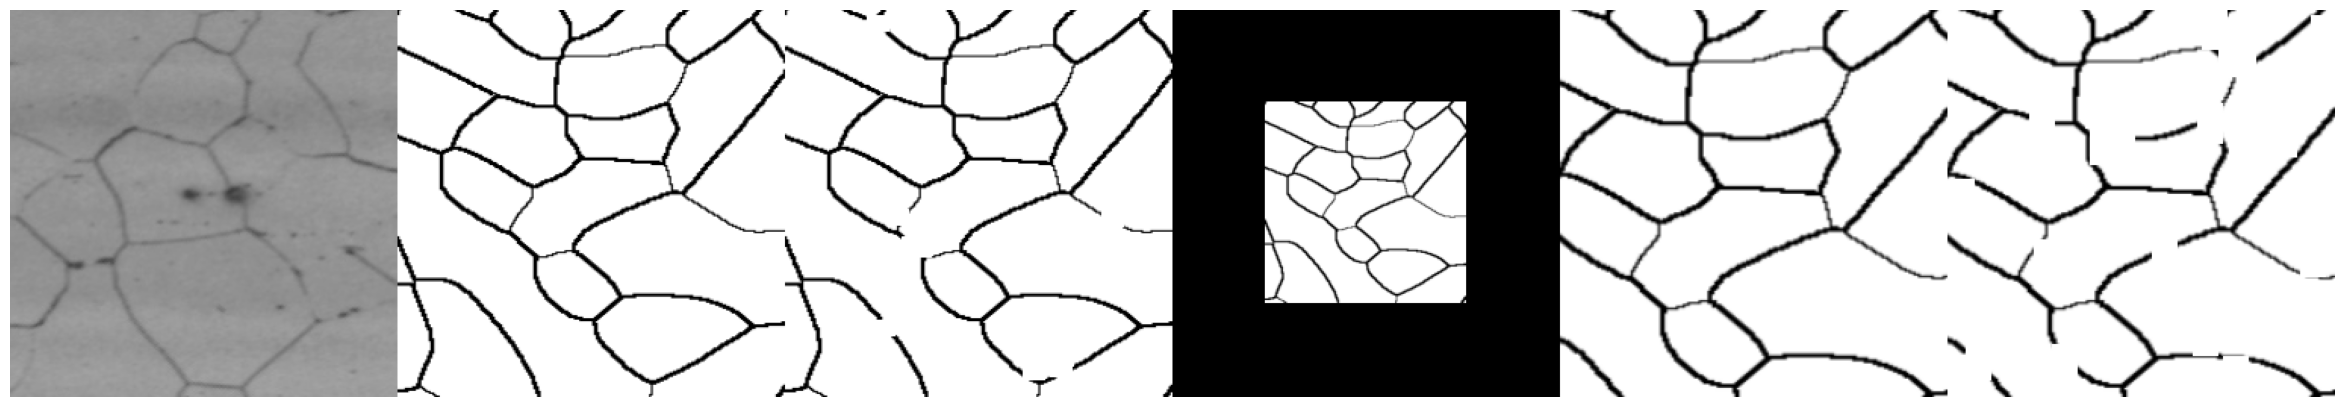

In [66]:
import time
import warnings
warnings.simplefilter("ignore")

total_white_show(real_A,real_B)

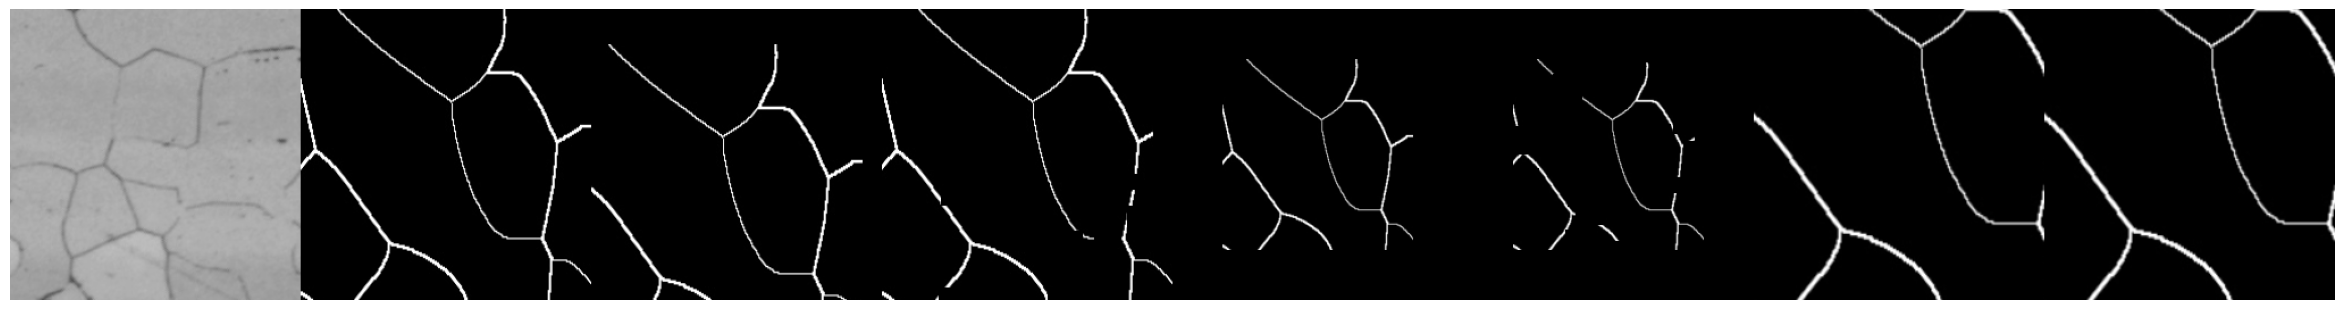

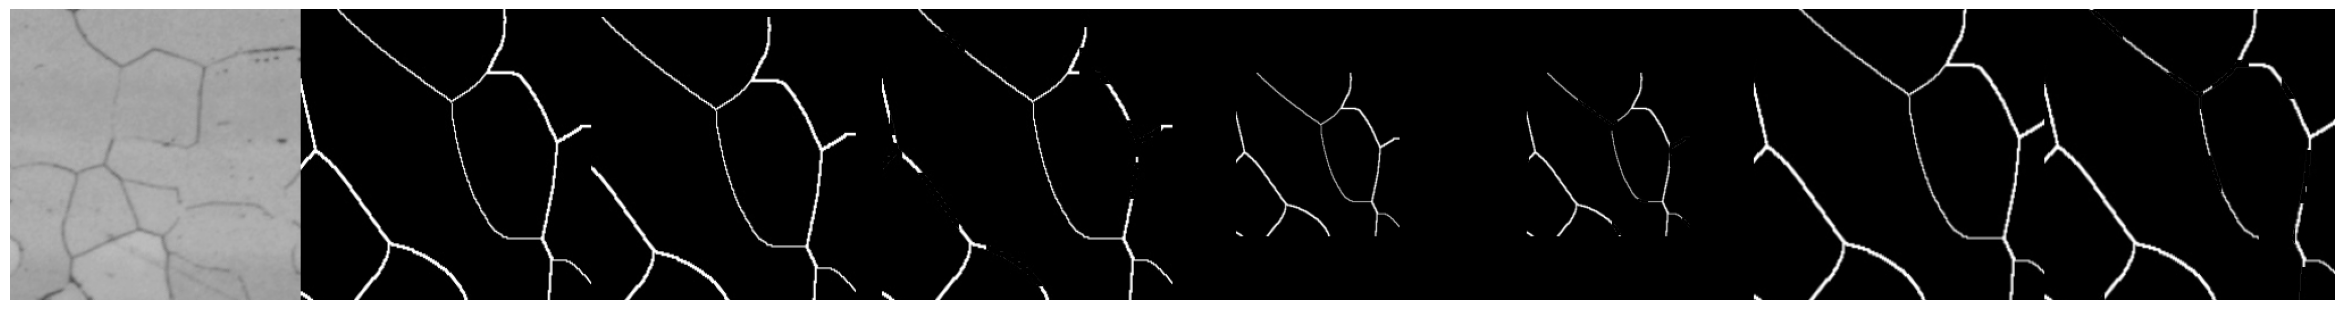

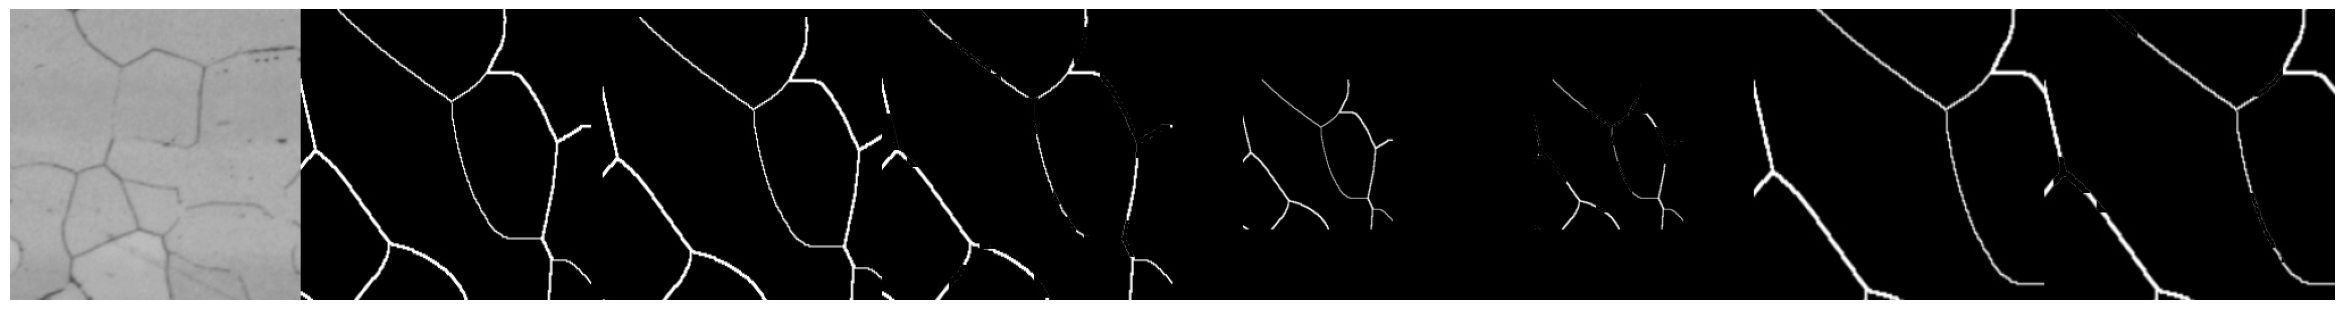

In [60]:
import time
import warnings
warnings.simplefilter("ignore")

black_total_show(real_A,real_B)

In [ ]:
white_normal(Name = "test2",
            file_path = "/content/drive/MyDrive/acta/data_files/trainA/magnesium_169.jpg",
            folder_path = "/content/drive/MyDrive/acta_result")

In [ ]:
black_normal(Name = "test2",
            file_path = "/content/drive/MyDrive/acta/data_files/trainA/magnesium_169.jpg",
            folder_path = "/content/drive/MyDrive/acta_result")